# Author : Deepak Wadge
# LGMVIPJUNE

## Data Science Intern June 2022
## TASK 2 : Stock Market Prediction And Forecasting Using Stacked LSTM


# Import important libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


# Reading the Dataset

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv")
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


Data Description:-

Open: The price of the stock when the market opens in the morning

Close: The price of the stock when the market closed in the evening

High: Highest price the stock reached during that day

Low: Lowest price the stock is traded on that day

Volume: The total amount of stocks traded on that day

In [ ]:
#Number of rows and columns of data

data.shape     

(2035, 8)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [ ]:
# Checking Null Values in the data
data.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [ ]:
data.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


# Data sorting

In [ ]:
data['Date']=pd.to_datetime(data['Date'])
print(type(data.Date[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [ ]:
df=data.sort_values(by='Date')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98



## Visualization

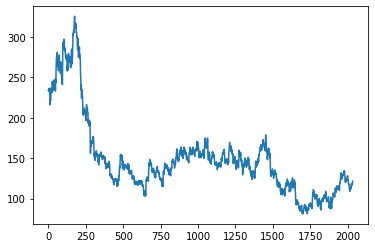

In [ ]:
plt.plot(df['Close'])

In [ ]:
dff=df['Close']
dff

2034    121.55
2033    120.90
2032    120.65
2031    117.60
2030    118.65
         ...  
4       233.30
3       236.10
2       234.25
1       233.25
0       233.75
Name: Close, Length: 2035, dtype: float64

#LSTM are sensitive to the scale of the data. so we apply MinMax scaler

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is that LSTM can store past important information and forget the information that is not. LSTM has three gates:

* The input gate: The input gate adds information to the cell state,
* The forget gate: It removes the information that is no longer required by the model,
* The output gate: Output Gate at LSTM selects the information to be shown as output



### MIN MAX Scaler

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
dff=scaler.fit_transform(np.array(dff).reshape(-1,1))
dff

array([[0.16584967],
       [0.16319444],
       [0.1621732 ],
       ...,
       [0.62622549],
       [0.62214052],
       [0.62418301]])

## Spliting The Dataset

In [ ]:
training_size=int(len(dff)*0.70)
test_size=len(dff)-training_size
train_data,test_data=dff[0:training_size,:],dff[training_size:len(dff),:1]


Convert an array of values into a dataset Matrixconvert an array of values into a dataset Matrix

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

## Spliting Data into Train and Test

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(1323, 100)
(1323,)


(None, None)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## Creating the LSTM Model

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_split=0.1,epochs=60,batch_size=64,verbose=1)

Epoch 1/60
19/19 [==============================] - 20s 608ms/step - loss: 0.0116 - val_loss: 0.0014
Epoch 2/60
19/19 [==============================] - 9s 466ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 3/60
19/19 [==============================] - 7s 385ms/step - loss: 9.4461e-04 - val_loss: 0.0012
Epoch 4/60
19/19 [==============================] - 7s 397ms/step - loss: 8.7165e-04 - val_loss: 0.0012
Epoch 5/60
19/19 [==============================] - 5s 252ms/step - loss: 8.3515e-04 - val_loss: 0.0011
Epoch 6/60
19/19 [==============================] - 3s 180ms/step - loss: 8.0520e-04 - val_loss: 0.0011
Epoch 7/60
19/19 [==============================] - 3s 182ms/step - loss: 7.8465e-04 - val_loss: 0.0011
Epoch 8/60
19/19 [==============================] - 3s 181ms/step - loss: 7.7143e-04 - val_loss: 0.0010
Epoch 9/60
19/19 [==============================] - 3s 180ms/step - loss: 7.4602e-04 - val_loss: 9.6614e-04
Epoch 10/60
19/19 [==============================] - 3s 179ms/step 

In [ ]:
test_predict=model.predict(X_test)

In [ ]:
test_predicted=scaler.inverse_transform(test_predict)
test_predicted

array([[144.31221 ],
       [144.59431 ],
       [143.9201  ],
       [141.63322 ],
       [139.92657 ],
       [139.07968 ],
       [139.78793 ],
       [141.11479 ],
       [141.7111  ],
       [141.67921 ],
       [141.59375 ],
       [142.56004 ],
       [143.26553 ],
       [144.66574 ],
       [146.68298 ],
       [145.33894 ],
       [143.31284 ],
       [142.64749 ],
       [142.83955 ],
       [146.89941 ],
       [151.07048 ],
       [153.7781  ],
       [154.86852 ],
       [153.51514 ],
       [153.1396  ],
       [152.59909 ],
       [152.66751 ],
       [154.0058  ],
       [154.82425 ],
       [155.11    ],
       [155.61661 ],
       [154.74753 ],
       [151.9392  ],
       [146.74976 ],
       [143.0517  ],
       [141.39362 ],
       [141.04845 ],
       [140.30873 ],
       [138.45998 ],
       [135.32063 ],
       [132.83139 ],
       [131.32869 ],
       [129.20831 ],
       [128.15298 ],
       [126.241066],
       [123.82619 ],
       [122.85793 ],
       [122.3


## Calculating Performance

In [ ]:
performance = math.sqrt(mean_squared_error(ytest,test_predict))
performance

0.029786024609107245